# Exercise 4: Saliency Maps

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy.stats as scp
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import os

%matplotlib inline

# 1. Saliency Maps from Local Standard Deviation

## 1. 

(99, 150, 3)

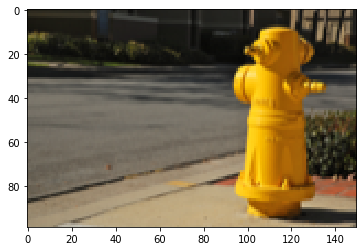

In [2]:
img = imread('salience_02.png')
plt.imshow(img)
img.shape

In [3]:
def show_components(img):
    fig, axs = plt.subplots(1, 4, figsize = (15, 10))

    axs[0].imshow(img)
    for i, ax in enumerate(axs.ravel()[1:]):
        ax.imshow(img[:, :, i], cmap = 'gray')

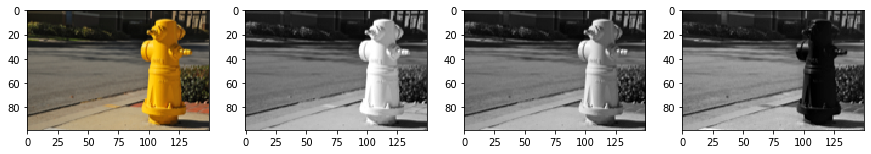

In [4]:
show_components(img)

In [5]:
red_comp = img[:, :, 0].flatten()
green_comp = img[:, :, 1].flatten()
blue_comp = img[:, :, 2].flatten()
all_comp = np.vstack((red_comp, green_comp, blue_comp))
np.corrcoef(all_comp)

array([[1.        , 0.94994194, 0.36971798],
       [0.94994194, 1.        , 0.59863754],
       [0.36971798, 0.59863754, 1.        ]])

**Is there anything striking in the correlations?**

There is very high correlation betweeen all colors, especially red and green.

**Why it is not suprising given the way natural images arise?**

Natural images have a lot of correlation between pixel values.


## 2. 

(99, 150, 3)


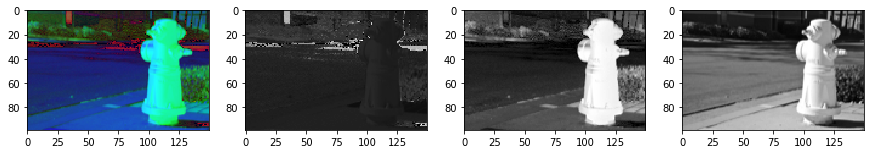

In [6]:
img_hsv = mlp.colors.rgb_to_hsv(img)
print(img_hsv.shape)
show_components(img_hsv)

In [7]:
hue_comp = img_hsv[:, :, 0].flatten()
saturation_comp = img_hsv[:, :, 1].flatten()
val_comp = img_hsv[:, :, 2].flatten()
all_comp = np.vstack((hue_comp, saturation_comp, val_comp))
np.corrcoef(all_comp)

array([[ 1.        , -0.22358772, -0.36745728],
       [-0.22358772,  1.        ,  0.55871773],
       [-0.36745728,  0.55871773,  1.        ]])

**Why is there less correlation?**

In RGB the color channels are correlated because in order to mix a certain color, the same combination needs to be used.
HSV seperates the image intensity from the color information, thus having different feature dimensions.

## 3.  & 4. & 5.

In [8]:
def x_in_border(img, x, x_half):
    return np.all(x + x_half + 1 < img.shape[1] and x - x_half > 0)

def y_in_border(img, y, y_half):
    return np.all(y + y_half + 1 < img.shape[0] and y - y_half > 0)

In [9]:
def extract_patch(img, l_x, l_y, x, y):
    """Extract patches from the img from position x, y with length l_x and l_y, respectively.
    Returns None if parts of the patch are not within the borders."""
    
    x_half = l_x//2
    y_half = l_y//2
    
    if not x_in_border(img, x, x_half+1):
        return -17
#         return None
        
    if not y_in_border(img, y, y_half+1):
        return -17
#         return None
    
    # Cave. Assuming x should be the horizontal direction and y the vertical,
    # the accesses has to be img[y, x].
    return img[y-y_half:y+y_half+1, x-x_half:x+x_half+1]

In [10]:
hue_comp = hue_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
saturation_comp = saturation_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
val_comp = val_comp.reshape(img_hsv.shape[0], img_hsv.shape[1])
val_comp.shape

(99, 150)

In [11]:
def calc_sal_map(img_component, patch_width, use_circ_std=False):
    patch_width_sided = patch_width //2
    y_half = patch_width_sided
    x_half = patch_width_sided
    
    start_x = patch_width_sided
    stop_x = img.shape[1]-patch_width_sided
    
    start_y = patch_width_sided
    stop_y = img.shape[0]-patch_width_sided
    
    x = np.linspace(start_x, stop_x, stop_x - start_x, dtype = int)
    y = np.linspace(start_y, stop_y, stop_y - start_y, dtype = int)
    xv, yv = np.meshgrid(x, y)
    
    sal_map = []
    for x, y in zip(xv, yv):
        for xx, yy in zip(x, y):
            patch = img_component[yy-y_half:yy+y_half+1, xx-x_half:xx+x_half+1]
            if use_circ_std:
                sal_map.append(scp.circstd(patch, high = 1))
            else:
                sal_map.append(np.std(patch))
    
    return np.array(sal_map).reshape(stop_y - start_y, stop_x - start_x)

In [12]:
patch_size = 15
sal_map_hue = calc_sal_map(hue_comp, patch_size, True)
sal_map_saturation = calc_sal_map(saturation_comp, patch_size)
sal_map_val = calc_sal_map(val_comp, patch_size)

In [13]:
sal_map = sal_map_hue + sal_map_saturation + sal_map_val
sal_map.shape

(85, 136)

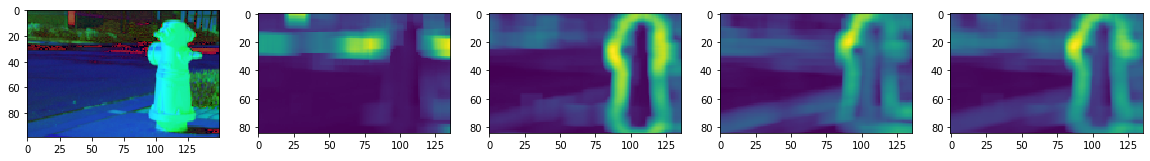

In [14]:
fig, axs = plt.subplots(1, 5, figsize = (20, 10))

axs[0].imshow(img_hsv)
axs[1].imshow(sal_map_hue)
axs[2].imshow(sal_map_saturation)
axs[3].imshow(sal_map_val)
axs[4].imshow(sal_map);

**How is each of the images related to the visual properties of the image?**

- Hue: The color is represnted by the angular dimension. Different Colors are represented by different values along the circle regardless of the other features. The blue property in the image actually relates to the values of the yellow.

- Saturation: As there is an edge representing high contrast in terms of saturation (see property above) from bright yellow to grey (huge brightness change), which shows up as higher values in the saturation salience map.

- Value: In line with the reasoning for the saturation, the highest contrast between the lightness of the image varies most strongly at the border of the hydrant.

## 6. 

In [15]:
sigmas = [2, 5, 10]
modes = ['reflect', 'nearest', 'constant', 'mirror', 'wrap']

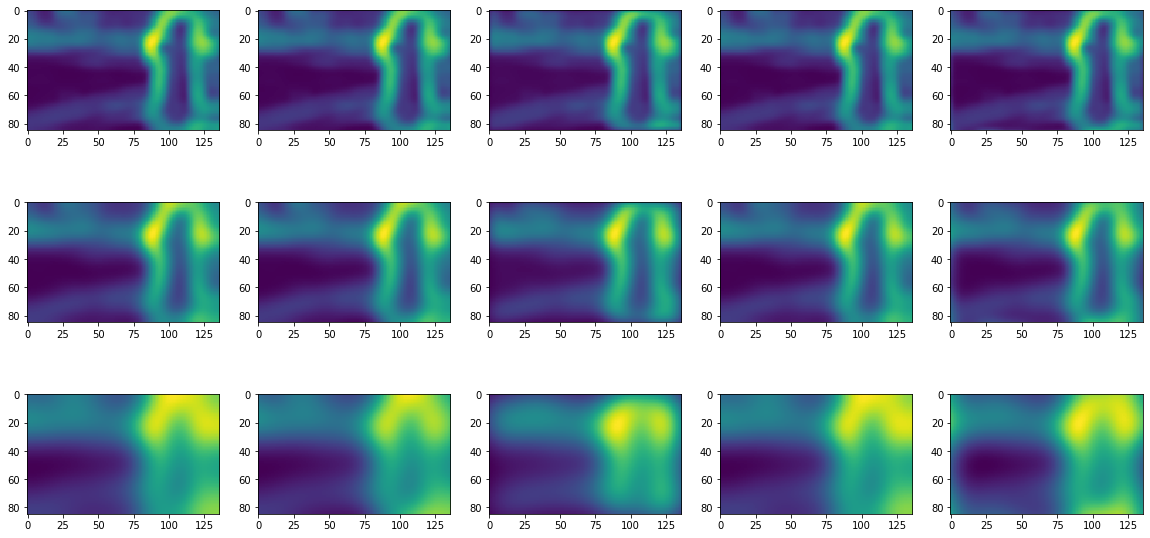

In [16]:
fig, axs = plt.subplots(len(sigmas), len(modes), figsize = (20, 10))
for i, s in enumerate(sigmas):
    for j, m in enumerate(modes):
        filtered_map = gaussian_filter(sal_map, sigma = s, mode = m)
        axs[i][j].imshow(filtered_map)

The best saliency map in our opinion is obtained for constant padding and sigma = 10. It shows that the attention is drawn toward the whole object in the foreground (the hydrant), not only to its borders.

## 7.

In [17]:
filtered_map = gaussian_filter(sal_map, sigma = 10, mode = 'constant')

In [18]:
def cut_image(img, patch_width_sided):
    patch_width_sided = 7
    start_x = patch_width_sided
    stop_x = img.shape[0]-patch_width_sided
    
    start_y = patch_width_sided
    stop_y = img.shape[1]-patch_width_sided

    img_section = img[start_x:stop_x, start_y:stop_y, :]
    return img_section

In [19]:
img_section = cut_image(img, 7)

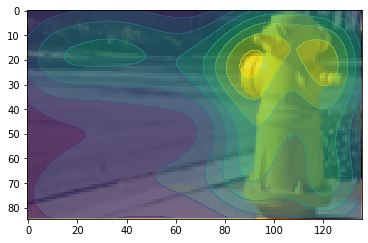

In [20]:
plt.imshow(img_section)
plt.contourf(filtered_map, alpha = 0.6);

## 8.

In [21]:
def get_min_max(img):
    max_idx = np.argmax(img)
    max_coord = np.unravel_index(max_idx, (img.shape[0], img.shape[1]))

    min_idx = np.argmin(img)
    min_coord = np.unravel_index(min_idx, (img.shape[0], img.shape[1]))
    
    return min_coord, max_coord

In [22]:
min_coord, max_coord = get_min_max(filtered_map)

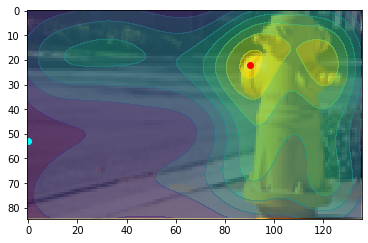

In [23]:
plt.imshow(img_section)
plt.plot(max_coord[1], max_coord[0], marker = 'o', color = 'red')
# Acqua is the best kind of blue for this map.
plt.plot(min_coord[1], min_coord[0], marker = 'o', color = 'aqua')

plt.contourf(filtered_map, alpha = 0.6);

**How do you interpret the completed image?**

The hydrant has high saliency as we would expect as this the brightest part of the image, so we ourselves would also focus on this. In line with our human experience, the provided center of attention is correct as is the center of least attention.

## 9.

In [24]:
all_img = []

for file in os.listdir("."):
    if file.endswith(".png") and 'salience' in file:
        all_img.append(imread(file))

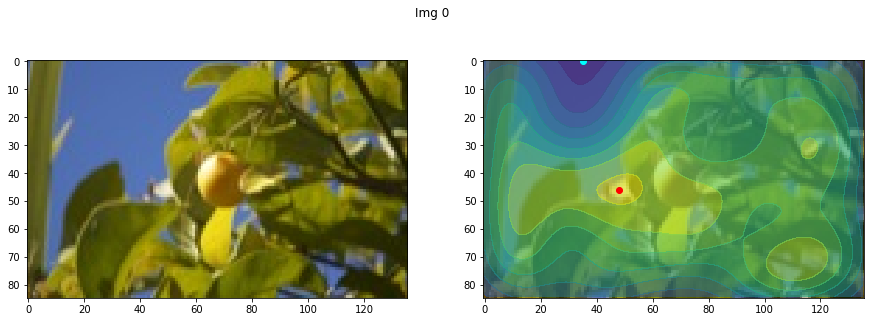

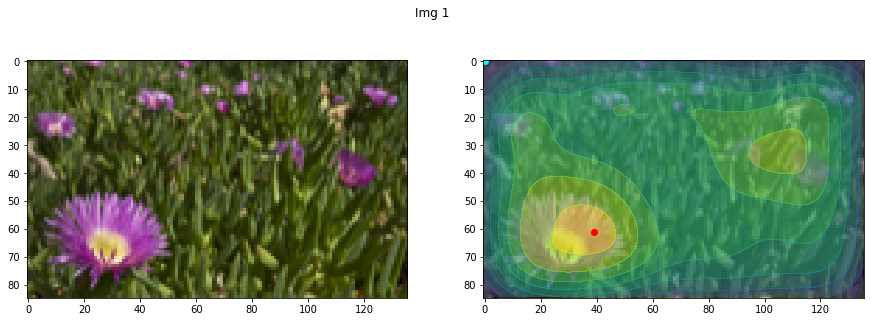

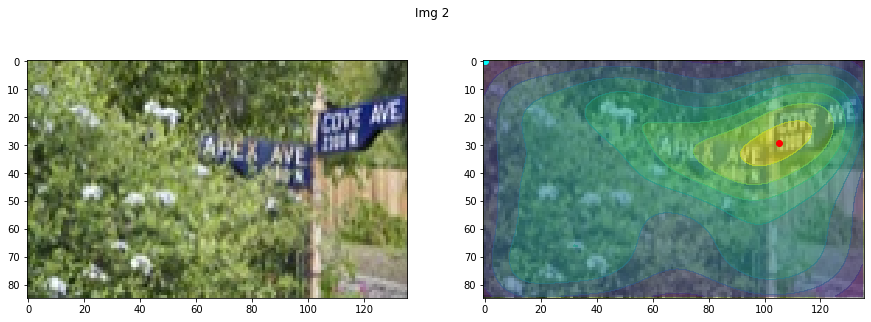

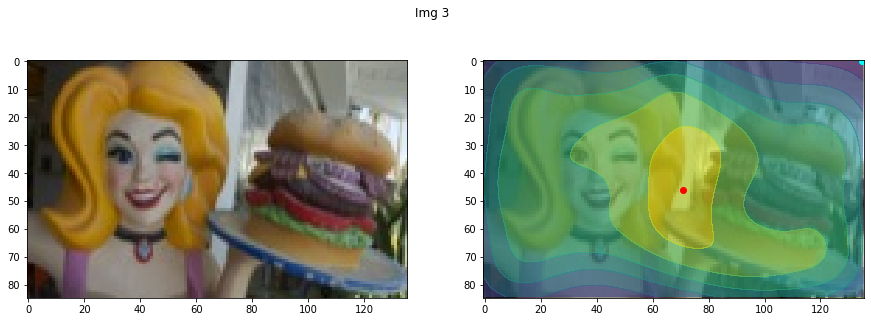

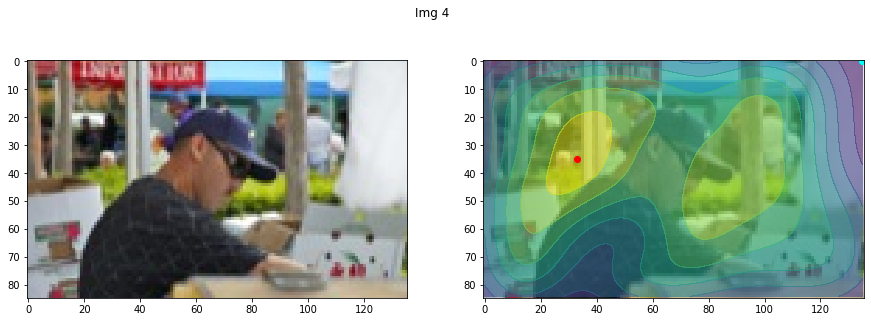

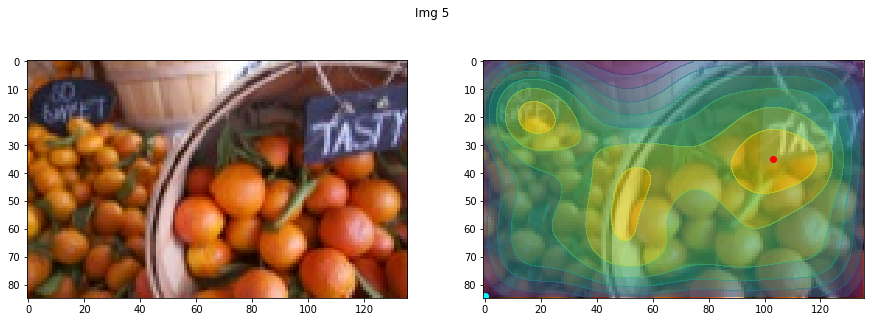

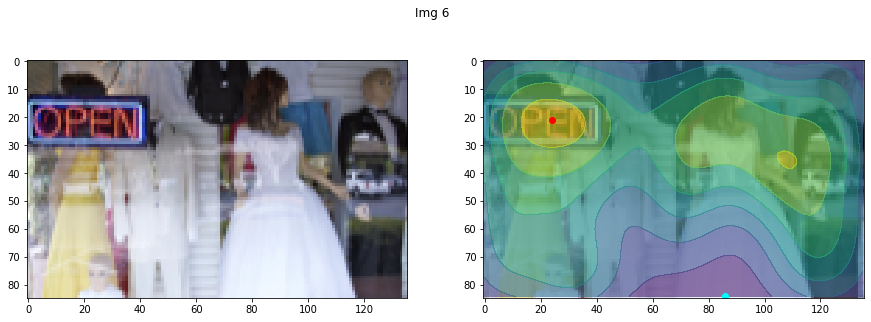

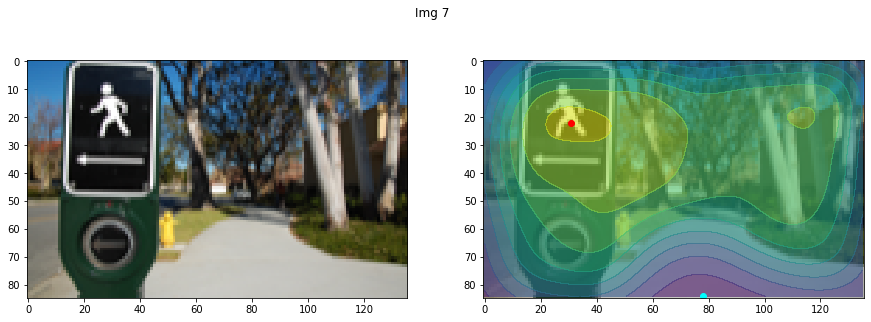

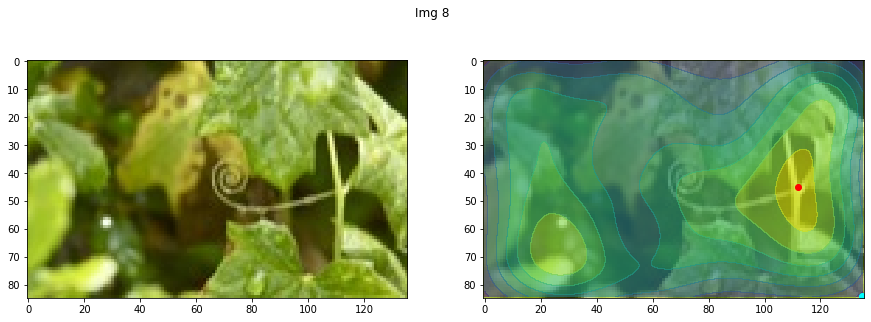

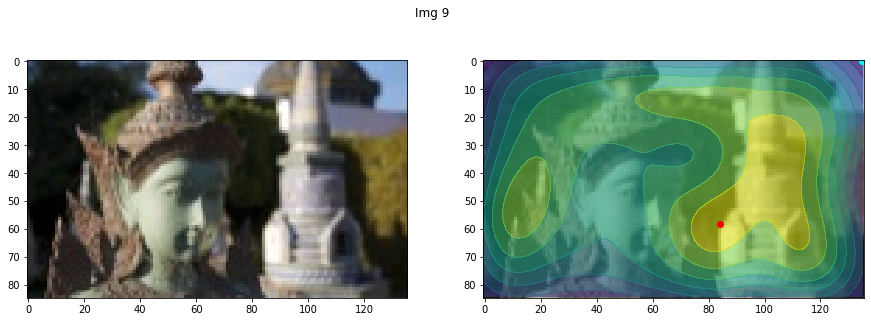

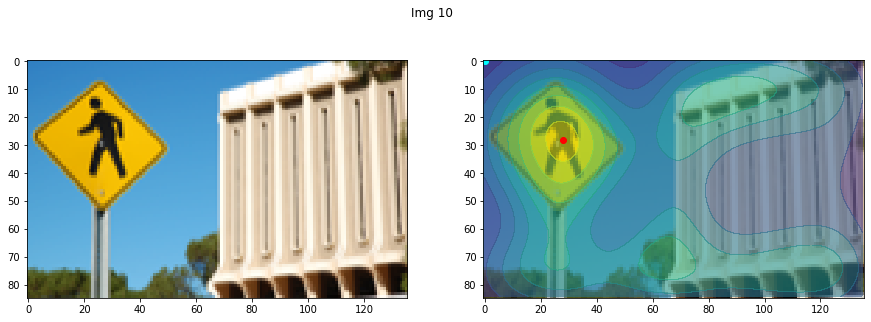

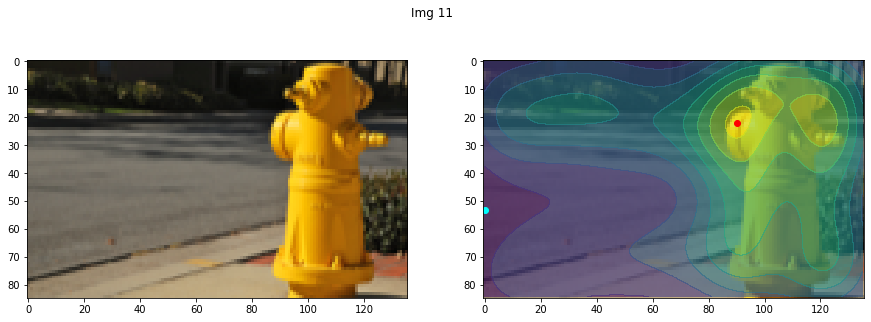

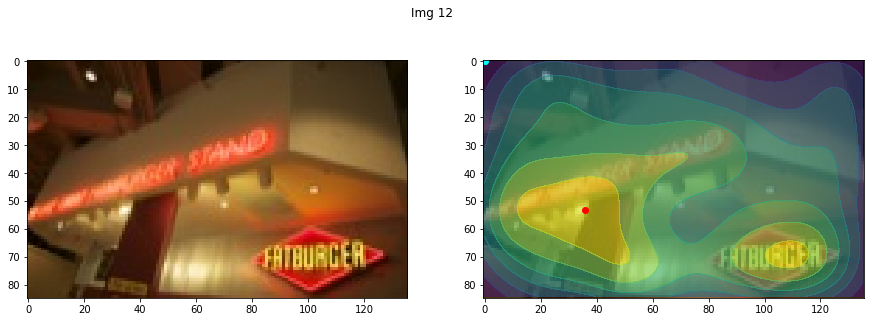

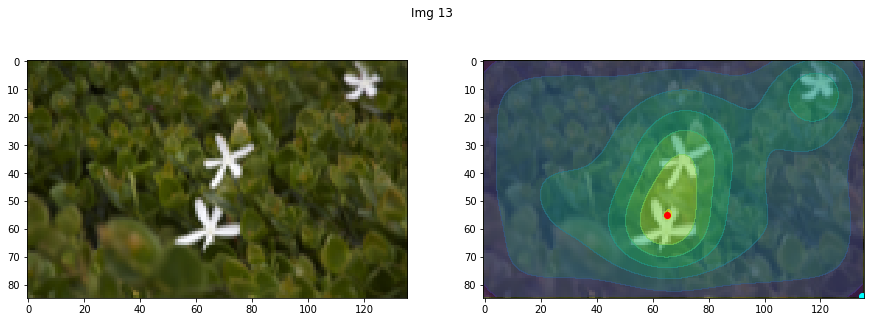

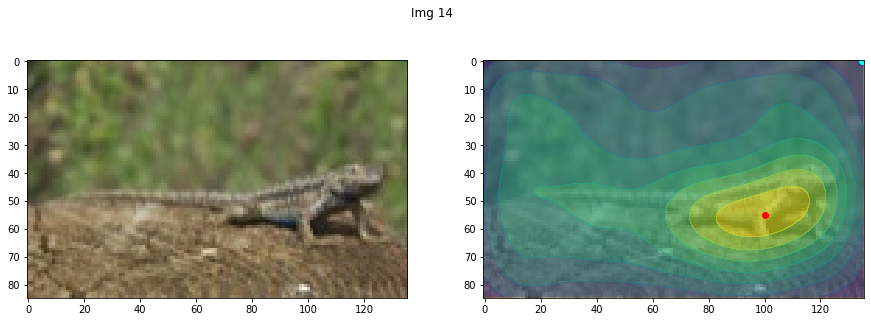

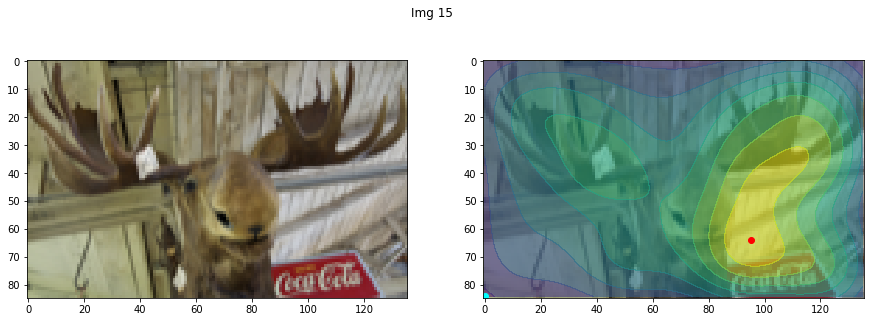

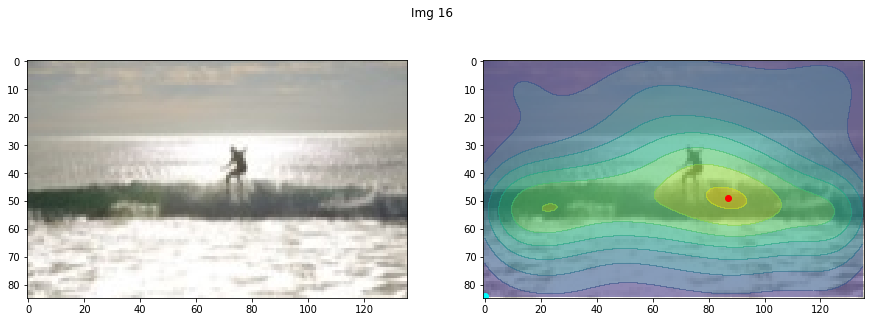

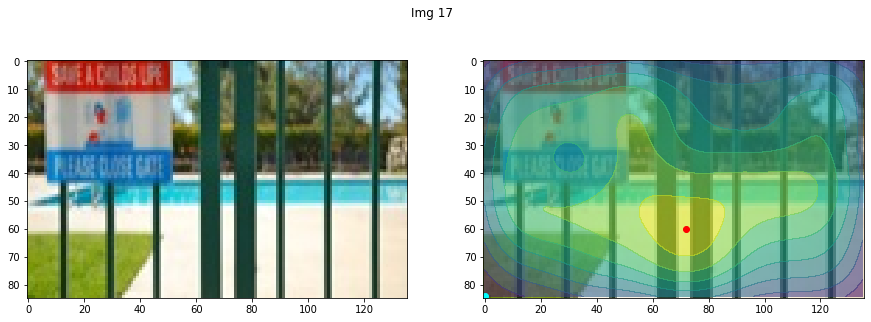

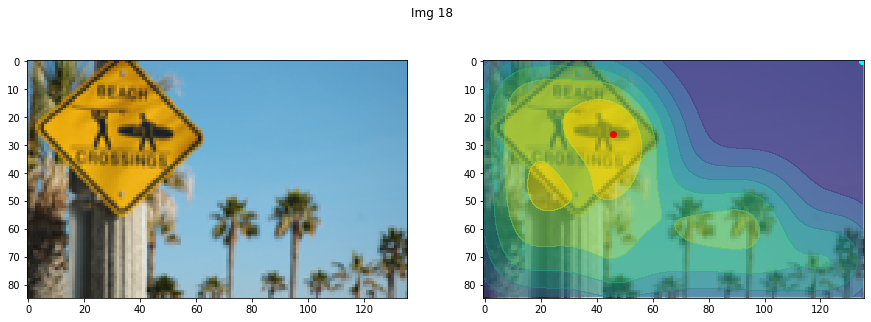

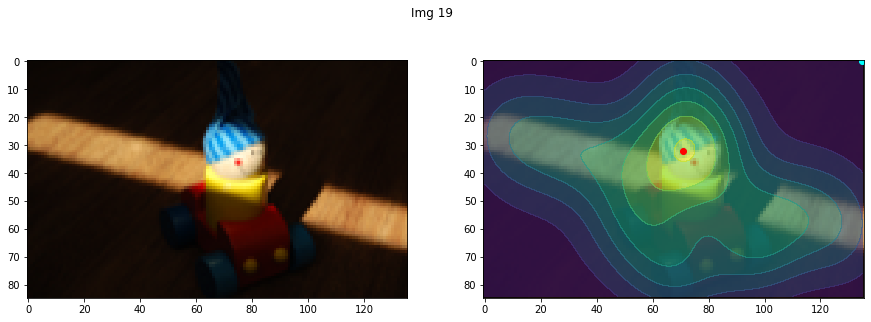

In [25]:
# fig, axs = plt.subplots(len(all_img), 2, figsize = (50, 10))

for i, img in enumerate(all_img):
    # Convert ot HSV.
    img_hsv = mlp.colors.rgb_to_hsv(img)
    # Get components.
    hue_comp = img_hsv[:, :, 0]
    saturation_comp = img_hsv[:, :, 1]
    val_comp = img_hsv[:, :, 2]
    
    # Get saliency map.
    patch_size = 15
    sal_map_hue = calc_sal_map(hue_comp, patch_size, True)
    sal_map_saturation = calc_sal_map(saturation_comp, patch_size)
    sal_map_val = calc_sal_map(val_comp, patch_size)
    sal_map = sal_map_hue + sal_map_saturation + sal_map_val
#     plt.imshow(sal_map)
#     plt.show()
    
    filtered_map = gaussian_filter(sal_map, sigma = 10, mode = 'constant')
    img_section = cut_image(img, 7)
    min_coord, max_coord = get_min_max(filtered_map)
    
    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    
    # Plotting.
    axs[0].imshow(img_section)
    axs[1].imshow(img_section)
    axs[1].plot(max_coord[1], max_coord[0], marker = 'o', color = 'red')
    # Acqua is the best kind of blue for this map.
    axs[1].plot(min_coord[1], min_coord[0], marker = 'o', color = 'aqua')
    axs[1].contourf(filtered_map, alpha = 0.6)
    plt.suptitle(f"Img {i}");

**Pick images for which the most salient position according
to the algorithm does not conform with your expectation of how human attention
works. Name at least two different image features the algorithm does not take into
account and illustrate each with a different image.**

What is not quite well captured is our attention to emotionally relevant simuli such as faces (image 4) and texts (such as fatburger in image 13). We would expect the attention to first go towards a face or the sign. Another good example is the Buddha in image 9 where even the reproduction of a face should draw attention, but to the saliency map, it does not.

## 10.

**We know from experiments that subjects are much more likely to first attend
the center of an image, instead of the borders. Please outline in words how this
information could be included in the above saliency-map analysis to better predict
eye-movements.**

We could overlay the saliencey map with additional mexican hat filter which has high values in the center at the center of the image and low values outside.

# 2. 

## 1.

In [26]:
# Taken from the helper.

def mexican_hat(x_size,y_size,width):
    '''generate a 2D-mexican hat filter'''
    x_linear=np.arange(-np.floor(x_size/2.0),np.ceil(x_size/2.0))
    y_linear=np.arange(-np.floor(y_size/2.0),np.ceil(y_size/2.0))
    x_grid, y_grid = np.meshgrid(x_linear,y_linear)
    t = np.sqrt(x_grid**2 + y_grid**2)

    mexican = 2.0 / np.sqrt(3.0) / width / np.pi**(1/4) * (1-1/2.0*t**2/width**2) \
            * np.exp(-t**2/2/width**2) 
    return np.real(mexican)

In [27]:
img = imread('salience_02.png')
img_hsv = mlp.colors.rgb_to_hsv(img)
# Get components.
hue_comp = img_hsv[:, :, 0]
saturation_comp = img_hsv[:, :, 1]
val_comp = img_hsv[:, :, 2]

hat = mexican_hat(20, 20, 3)
hat.shape

(20, 20)

## 2.

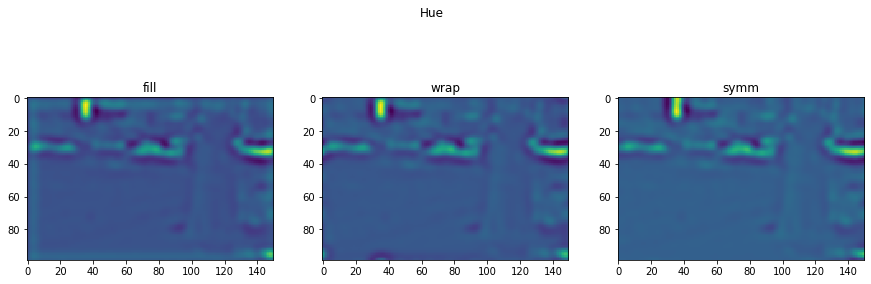

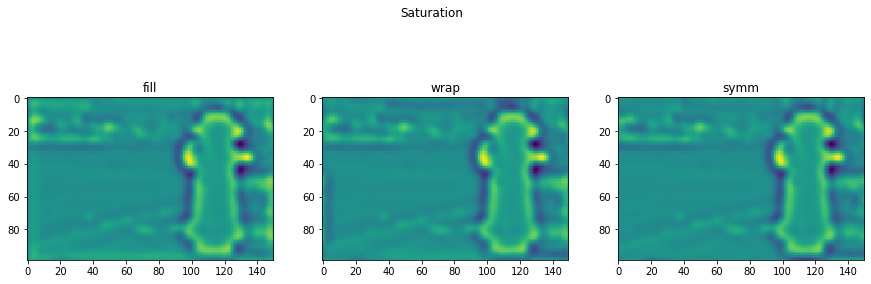

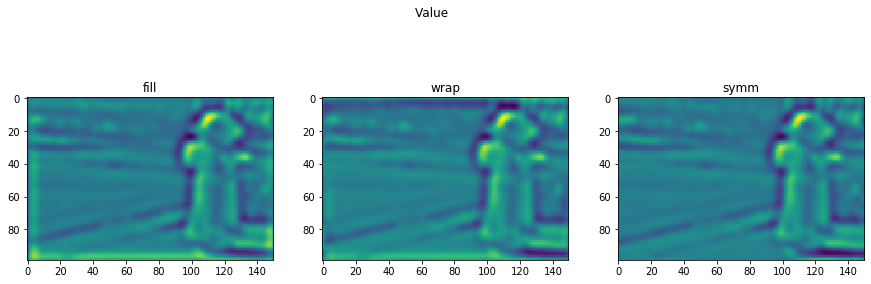

In [28]:
all_comp = [hue_comp, saturation_comp, val_comp]
all_comp_names = ["Hue", "Saturation", "Value"]
all_boundary_conditions = ['fill', 'wrap', 'symm']

for j, c in enumerate(all_comp):
    fig, axs = plt.subplots(1, len(all_boundary_conditions), figsize = (15, 5))
    for i, boundary in enumerate(all_boundary_conditions):
        # Use mode = 'same' to get original image dimensions.
        c_conv = convolve2d(c, hat, boundary=boundary, mode = 'same')
        axs[i].imshow(c_conv)
        axs[i].set_title(boundary)
    plt.suptitle(all_comp_names[j])

**Try out what happens with different boundary conditions and explain which one produces
the best result.**

The boundary flag indicates how the boundaries are handled: 

fill

    pad input arrays with fillvalue. (default)

wrap

    circular boundary conditions.
symm

    symmetrical boundary conditions.

As the attention of a viewer should not be at the image edges (see statement in exercise above), it might be a good idea to give the images less weight at the edges. Thus, option fill with default value 0 seems like a good idea.
Wrap would make sense if we lived on a torus.

## 3. 

In [29]:
all_comp = [hue_comp, saturation_comp, val_comp]
sal_maps = []
for c in all_comp:
    c_conv = convolve2d(c, hat, boundary='fill', mode = 'same')
    sal_maps.append(np.abs(c_conv))

## 4.

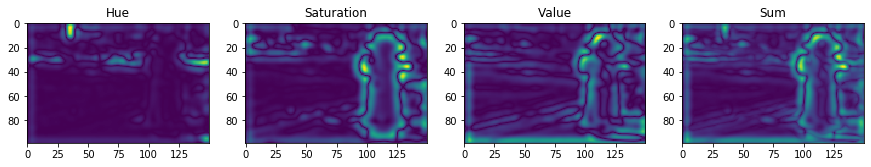

In [31]:
comb_sal_map = sal_maps[0] + sal_maps[1] + sal_maps[2]

fig, axs = plt.subplots(1, 4, figsize = (15, 5))

for i in range(len(sal_maps)):
    axs[i].imshow(sal_maps[i])
    axs[i].set_title(all_comp_names[i])
    
axs[3].imshow(comb_sal_map)
axs[3].set_title("Sum");

**In which aspects do the saliency
maps obtained by convolution differ from the saliency maps that you obtained by
computing standard deviation on image patches. Can you give an intuition why?**

The convoluted saliency maps seem a lot 'sharper' than the saliency maps computed by simply taking the standard deviation.

# TODO: intuition (check)
It could be because the standard deviation includes all pixels of the patch with equal weight. The mexican hat however takes only the center with the most weight which means the result should be sharper.

## 5. 

**Do you think that computing the standard
deviation across patches is a valid shortcut? What is the disadvantage of using the
convolution technique on HSV-represented images?**